In [1]:
import utils.transformer as transformer
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)


model = transformer.GPTModel(GPT_CONFIG_124M)


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (output_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_skip_layer): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_fea

In [13]:
model_save_path = "model_weights/gpt2_model_weights.pth"

checkpoint = torch.load(model_save_path)

model.load_state_dict(checkpoint["model_state_dict"])

# model.eval()

<All keys matched successfully>

In [14]:
import tiktoken

from utils.transformer import generate_text

def text_to_token_ids(text,tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids,tokenizer):
    ids = token_ids.squeeze(0).tolist()
    text = tokenizer.decode(ids)
    return text

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text(
    model=model,
    input=text_to_token_ids("Every effort moves you",tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print(f"Output text: {token_ids_to_text(token_ids,tokenizer)}")

Output text: Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




### Strategy 1

Temperature scaling , what happens in temperature scaling is the logits, output of the linear_head layer are divided by the temperature before softmax and cross entropy is applied to them 

#### Now what happens from dividing ?
So if we divide the logits by 0.1 (basically multiplying em by 10 ) what happens is the probabily distribution shrinks and we have more deterministic output 

but if we divde the logits by 1.5 then probabily distribution expands and hence there can be varied outputs (basically more creativity)

ALSO WHY IT'S CALLED TEMPERATURE :
    - Because in high temeprature entropy increases (i.e. multiple tokens have decent probabilites of output)
    - But in low temperature the entropy decreases hence the most likely will be apparent

# ![Temperature Scaling](./temperature_scaling.png)


In [15]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

next_token_logits2 = next_token_logits/0.1

next_token_logits3 = next_token_logits/5

probs = torch.softmax(next_token_logits, dim=0)

probs2 = torch.softmax(next_token_logits2, dim=0)

probs3 = torch.softmax(next_token_logits3, dim=0)


print(probs)
print(probs2)
print(probs3)





tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])
tensor([1.8530e-10, 3.5189e-26, 2.6890e-38, 9.9099e-01, 5.7569e-23, 4.4220e-37,
        2.9718e-38, 9.0133e-03, 2.8514e-22])
tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898])


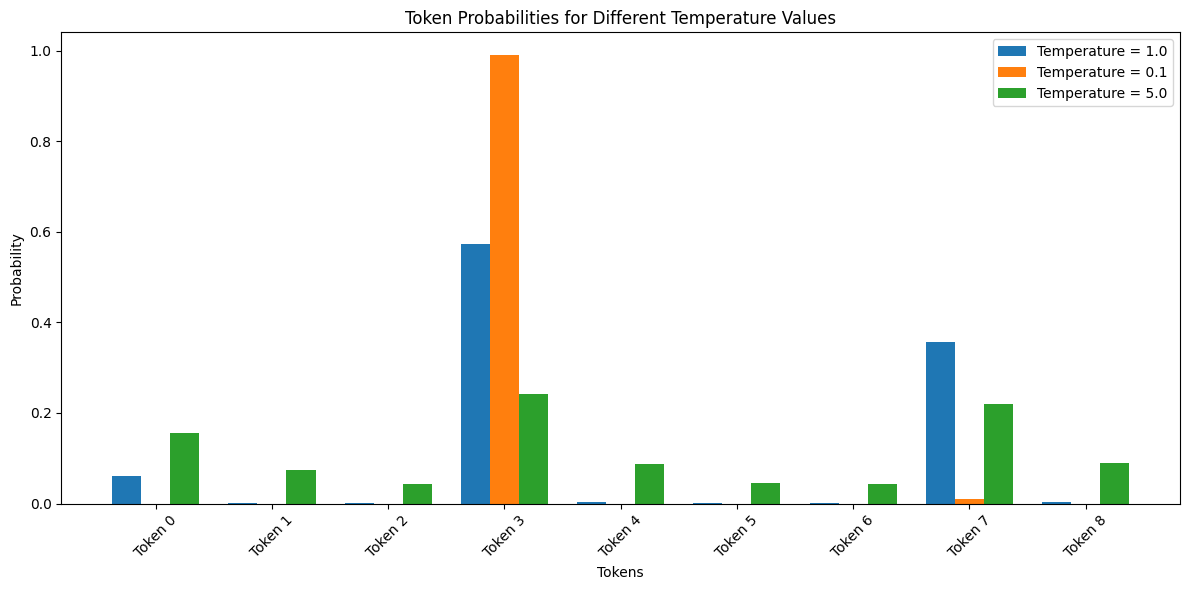

In [16]:
# plot these probabilities for different temperatures
import matplotlib.pyplot as plt
import numpy as np

# Create labels for tokens
token_labels = [f"Token {i}" for i in range(len(probs))]

# Set up the figure and axis
plt.figure(figsize=(12, 6))

# Create x positions for the bars
x = np.arange(len(token_labels))
width = 0.25  # width of the bars

# Plot bars for each temperature
plt.bar(x - width, probs.numpy(), width, label='Temperature = 1.0')
plt.bar(x, probs2.numpy(), width, label='Temperature = 0.1')
plt.bar(x + width, probs3.numpy(), width, label='Temperature = 5.0')

# Add labels, title and legend
plt.xlabel('Tokens')
plt.ylabel('Probability')
plt.title('Token Probabilities for Different Temperature Values')
plt.xticks(x, token_labels, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

### Top K Sampling

In topK sampling we set all the logits which are below the top k values to -inf , why -inf because then when softmax is applied these values are 0, hence we will just be sampling from topk values

In [17]:
def generate(model,idx,max_new_tokens,context_size,temperature=0.0,top_k=None,eos_id=None):
    """
    Generate text using the specified decoding strategy.
    
    Args:
        model: The model to use for generation
        idx: The input tokens ids
        max_new_tokens: The maximum number of new tokens to generate
        context_size: The size of the context window
        temperature: The temperature for the softmax function
        top_k: The number of top tokens to sample from
        eos_id: The end-of-sequence token id
    Returns:
        The generated text
    """
    for _ in range(max_new_tokens):
        idx_cond = idx[:,-context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:,-1,:] # because we want the next token that will be output of the last input

        if top_k is not None:
            top_logits, _ = torch.topk(logits,top_k)
            min_val = top_logits[:,-1]
            logits = torch.where(logits < min_val, torch.tensor(float('-inf')).to(logits.device), logits)

        if temperature > 0.0:
            logits = logits / temperature

            probs = torch.softmax(logits,dim=-1)

            idx_next = torch.multinomial(probs,num_samples=1)
        else:
            idx_next = torch.argmax(logits,dim=-1,keepdim=True)

        if idx_next == eos_id:
            break

        idx = torch.cat((idx,idx_next),dim=-1)

    return idx

In [18]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you stand," was one of the bean. The mere outline of the frame called
